In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
site_dic = {}
with open('site_dic.pkl', 'rb') as f:
    site_dic = pickle.load(f)

id2site = {v: k for (k, v) in site_dic.items()}
id2site[0] = 'no-site'

In [3]:
len(id2site)

48372

In [4]:
df = pd.read_csv('train_sessions.csv',index_col="session_id")
df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


# Pre Processing

In [5]:
sites = ['site%s' % i for i in range(1, 11)]

df['time1'] = pd.to_datetime(df['time1'])
df['hour1'] = df['time1'].dt.hour
df['day1'] = df['time1'].dt.day
df['month1'] = df['time1'].dt.month
df['day_of_week1'] = df['time1'].dt.day_of_week
df['null_count'] = df[sites].isnull().sum(axis=1)
df.sort_values(by='time1', inplace=True)

In [228]:
df[sites].fillna(0).astype('int').apply(lambda row: ' '.join([id2site[i] for i in row]), axis=1).tolist()

['safebrowsing.clients.google.com safebrowsing-cache.google.com no-site no-site no-site no-site no-site no-site no-site no-site',
 'safebrowsing.clients.google.com safebrowsing-cache.google.com safebrowsing.clients.google.com safebrowsing-cache.google.com no-site no-site no-site no-site no-site no-site',
 'www.apache.org www.apache.org download.eclipse.org www.apache.org www.apache.org www.webtide.com download.oracle.com javadl-esd-secure.oracle.com www.caucho.com www.apache.org',
 'www.webtide.com download.oracle.com www.caucho.com download.oracle.com www.webtide.com www.apache.org public.dhe.ibm.com www.webtide.com www.apache.org www.apache.org',
 'public.dhe.ibm.com jope.ow2.org download.oracle.com public.dhe.ibm.com jope.ow2.org master.dl.sourceforge.net www.apache.org download.eclipse.org www.apache.org public.dhe.ibm.com',
 'master.dl.sourceforge.net public.dhe.ibm.com download.jboss.org www.apache.org public.dhe.ibm.com www.apache.org download.jboss.org dfn.dl.sourceforge.net ww

In [229]:
df[df['target'] == 1][sites].isnull().sum(axis=1).value_counts(normalize=True)

0    0.983021
8    0.003047
5    0.003047
3    0.002612
6    0.002612
1    0.001741
4    0.001741
9    0.001306
2    0.000435
7    0.000435
Name: proportion, dtype: float64

In [230]:
df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,day_of_week1,null_count,alice_opening_hours,alice_off_hours,alice_opening_days_of_week,alice_off_days_of_week,alice_opening_days,alice_off_days,alice_opening_months,alice_off_months
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,5,8,0,1,0,0,0,0,0,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,5,6,0,1,0,0,0,0,0,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,5,0,0,1,0,0,0,0,0,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,5,0,0,1,0,0,0,0,0,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,5,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,50,2014-04-30 23:33:48,50.0,2014-04-30 23:33:49,48.0,2014-04-30 23:33:52,49.0,2014-04-30 23:33:52,48.0,2014-04-30 23:33:53,...,2,0,0,0,0,1,0,0,0,0
164438,4207,2014-04-30 23:34:15,753.0,2014-04-30 23:34:16,753.0,2014-04-30 23:34:17,52.0,2014-04-30 23:34:18,50.0,2014-04-30 23:34:18,...,2,0,0,0,0,1,0,0,0,0
12221,52,2014-04-30 23:38:08,3346.0,2014-04-30 23:38:10,784.0,2014-04-30 23:38:13,784.0,2014-04-30 23:38:18,3346.0,2014-04-30 23:38:22,...,2,0,0,0,0,1,0,0,0,0


In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer
features = 25000 #9726
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=features, tokenizer=lambda s: s.split())
X_tfidf = vectorizer.fit_transform(df[sites].fillna(0).astype(str).apply(lambda row: ' '.join(row), axis=1))

/Users/sofa/Library/Python/3.9/lib/python/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [233]:
vectorizer.get_feature_names_out()

array(['0.0', '0.0 0.0', '0.0 0.0 0.0', ..., '9962.0', '997.0', '9997.0'],
      dtype=object)

In [234]:
X_tfidf.shape

(253561, 25000)

In [235]:
# alice_sites = set(df[df['target'] == 1][sites].fillna(0).astype('int').to_numpy().ravel())

In [236]:
# def num_of_common_sites_with_alice(row):
#   row_sites = row[sites].fillna(0).astype('int').to_numpy().ravel()
#   total = 0
#   for i in range(len(sites)):
#     global alice_sites
#     if row_sites[i] in alice_sites and row_sites[i] != 0:
#       total += 1
#   return total

In [237]:
# df['num_of_common_sites_with_alice'] = df.apply(num_of_common_sites_with_alice, axis=1)

In [238]:
df


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,day_of_week1,null_count,alice_opening_hours,alice_off_hours,alice_opening_days_of_week,alice_off_days_of_week,alice_opening_days,alice_off_days,alice_opening_months,alice_off_months
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,5,8,0,1,0,0,0,0,0,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,5,6,0,1,0,0,0,0,0,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,5,0,0,1,0,0,0,0,0,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,5,0,0,1,0,0,0,0,0,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,5,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,50,2014-04-30 23:33:48,50.0,2014-04-30 23:33:49,48.0,2014-04-30 23:33:52,49.0,2014-04-30 23:33:52,48.0,2014-04-30 23:33:53,...,2,0,0,0,0,1,0,0,0,0
164438,4207,2014-04-30 23:34:15,753.0,2014-04-30 23:34:16,753.0,2014-04-30 23:34:17,52.0,2014-04-30 23:34:18,50.0,2014-04-30 23:34:18,...,2,0,0,0,0,1,0,0,0,0
12221,52,2014-04-30 23:38:08,3346.0,2014-04-30 23:38:10,784.0,2014-04-30 23:38:13,784.0,2014-04-30 23:38:18,3346.0,2014-04-30 23:38:22,...,2,0,0,0,0,1,0,0,0,0


In [239]:
df["target"].value_counts(normalize=True)

target
0    0.990941
1    0.009059
Name: proportion, dtype: float64

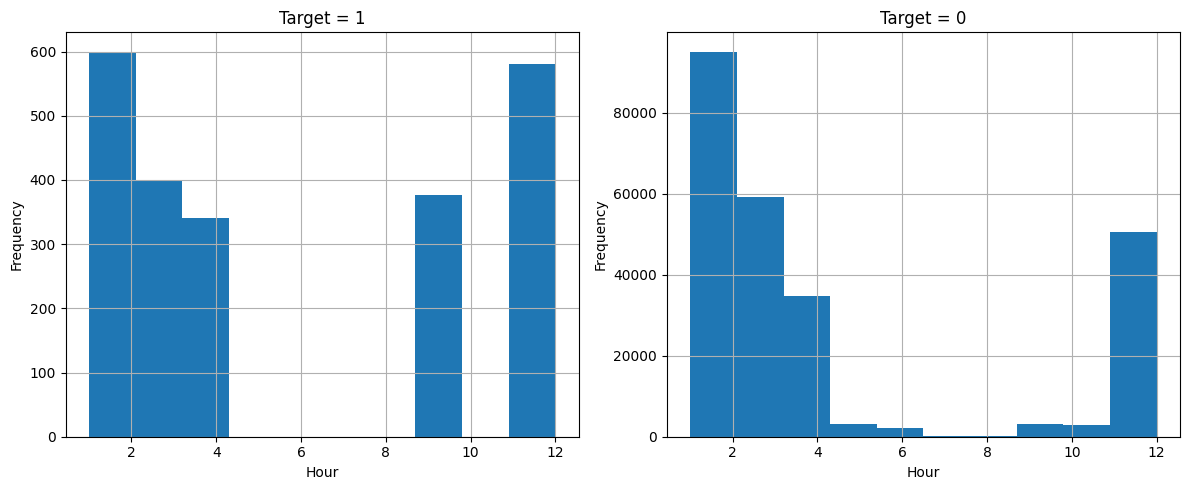

In [240]:
plt.figure(figsize=(12, 5))

# Plot for target = 1
plt.subplot(1, 2, 1)
pd.to_datetime(df[df["target"] == 1]['time1']).dt.month.hist()
plt.title("Target = 1")
plt.xlabel("Hour")
plt.ylabel("Frequency")

# Plot for target = 0
plt.subplot(1, 2, 2)
pd.to_datetime(df[df["target"] == 0]['time1']).dt.month.hist()
plt.title("Target = 0")
plt.xlabel("Hour")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [241]:
pd.to_datetime(df[df["target"]==1]['time1']).dt.month.value_counts(normalize=True) * 100

time1
2     20.505007
11    19.416630
3     17.414018
9     16.412712
4     14.801916
12     5.833696
1      5.616021
Name: proportion, dtype: float64

In [242]:
pd.to_datetime(df[df["target"]==0]['time1']).dt.month.value_counts(normalize=True)* 100

time1
3     23.555702
2     23.489636
1     14.368553
4     13.874252
11    13.550290
12     6.534163
5      1.285103
9      1.228588
10     1.109590
6      0.833386
8      0.115416
7      0.055320
Name: proportion, dtype: float64

## Opening Hours Of Alice

<Axes: >

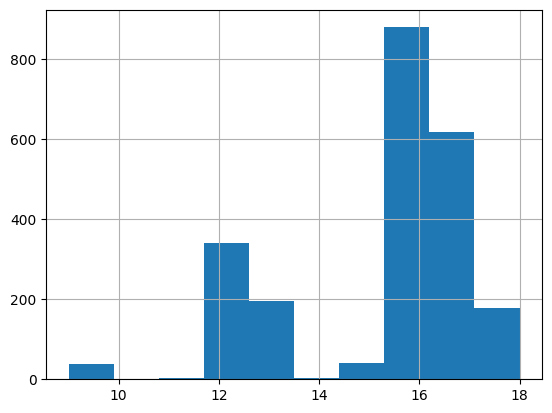

In [243]:
df[df['target'] == 1]['hour1'].hist()

In [244]:
df[df['target'] == 1]['hour1'].value_counts()

hour1
16    879
17    618
12    340
13    196
18    179
15     40
9      38
14      4
11      3
Name: count, dtype: int64

<Axes: >

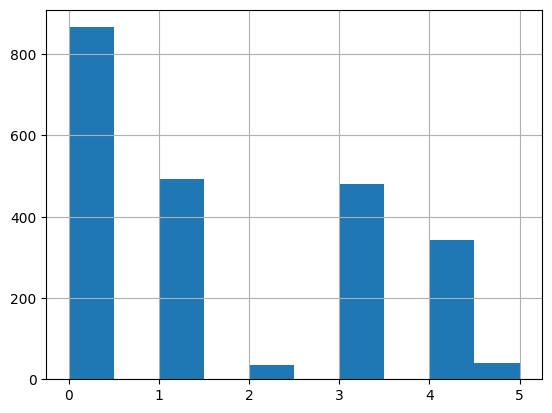

In [245]:
df['hour10'] = pd.to_datetime(df['time10']).dt.day_of_week
df[df['target'] == 1]['hour10'].hist()

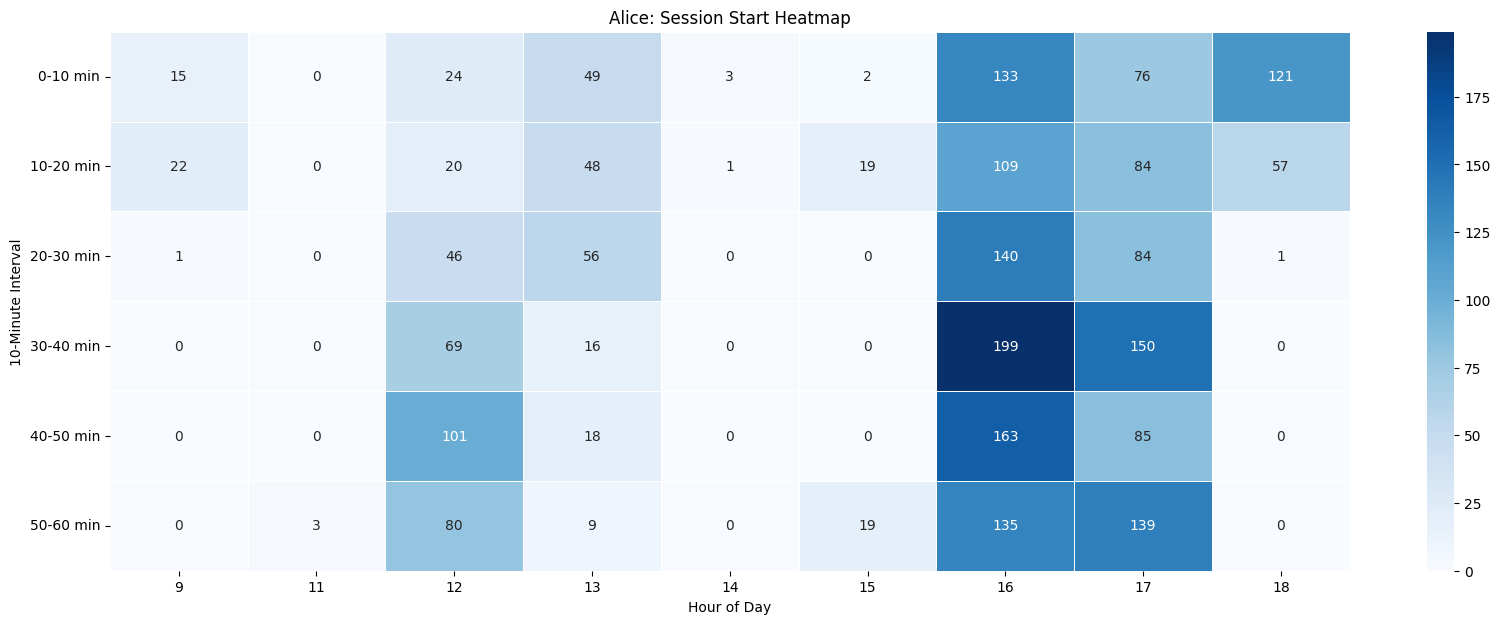

In [246]:
session_hours = pd.to_datetime(df['time1']).dt.hour
session_minutes = pd.to_datetime(df['time1']).dt.minute // 10  # Group into 10-minute bins

temp = pd.DataFrame({'hour': session_hours, 'minute_bin': session_minutes, 'y': df['target']})

# Filter for y_train == 1 and create a pivot table for heatmap
df_filtered = temp[temp['y'] == 1]
heatmap_data = df_filtered.pivot_table(index='minute_bin', columns='hour', aggfunc='size', fill_value=0)

# Plot heatmap
plt.figure(figsize=(20, 7))
sns.heatmap(heatmap_data, cmap="Blues", annot=True, fmt='d', linewidths=0.5)

# Labels
plt.title("Alice: Session Start Heatmap")
plt.xlabel("Hour of Day")
plt.ylabel("10-Minute Interval")
plt.yticks(ticks=np.arange(6) + 0.5, labels=[f"{i*10}-{(i+1)*10} min" for i in range(6)], rotation=0)
plt.xticks(rotation=0)

plt.show()

Text(0, 0.5, 'Frequency')

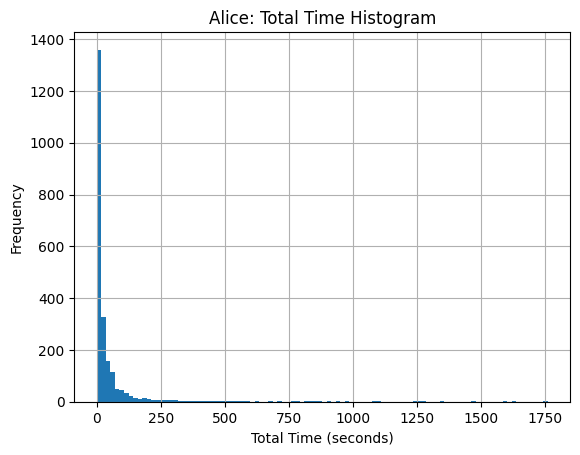

In [247]:
df["total_time"] = pd.to_datetime(df["time10"]) - pd.to_datetime(df["time1"])
df["total_time"] = df["total_time"].dt.total_seconds() # Convert to minutes
df[df['target'] == 1]["total_time"].hist(bins=100)
plt.title("Alice: Total Time Histogram")
plt.xlabel("Total Time (seconds)")
plt.ylabel("Frequency")

In [248]:
df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,alice_opening_hours,alice_off_hours,alice_opening_days_of_week,alice_off_days_of_week,alice_opening_days,alice_off_days,alice_opening_months,alice_off_months,hour10,total_time
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,NaN,NaN
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,0,1,0,0,0,0,0,0,NaN,NaN
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,0,1,0,0,0,0,0,0,5.0,4.0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,0,1,0,0,0,0,0,0,5.0,3.0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,0,1,0,0,0,0,0,0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,50,2014-04-30 23:33:48,50.0,2014-04-30 23:33:49,48.0,2014-04-30 23:33:52,49.0,2014-04-30 23:33:52,48.0,2014-04-30 23:33:53,...,0,0,0,1,0,0,0,0,2.0,12.0
164438,4207,2014-04-30 23:34:15,753.0,2014-04-30 23:34:16,753.0,2014-04-30 23:34:17,52.0,2014-04-30 23:34:18,50.0,2014-04-30 23:34:18,...,0,0,0,1,0,0,0,0,2.0,178.0
12221,52,2014-04-30 23:38:08,3346.0,2014-04-30 23:38:10,784.0,2014-04-30 23:38:13,784.0,2014-04-30 23:38:18,3346.0,2014-04-30 23:38:22,...,0,0,0,1,0,0,0,0,2.0,28.0


## Feature Engineering

In [249]:
# def pre_process(df):
#   df['time1'] = pd.to_datetime(df['time1'])
#   df['hour1'] = df['time1'].dt.hour
#   df['day1'] = df['time1'].dt.day
#   df['month1'] = df['time1'].dt.month
#   df['day_of_week1'] = df['time1'].dt.day_of_week
  
#   df['morning'] = df['hour1'].apply(lambda x: 1 if x >= 7 and x < 12 else 0)
#   df['afternoon_1'] = df['hour1'].apply(lambda x: 1 if x >= 12 and x < 14 else 0)
#   df['afternoon_3'] = df['hour1'].apply(lambda x: 1 if x >= 16 and x <= 18 else 0)
#   df['evening'] = df['hour1'].apply(lambda x: 1 if x > 18 and x < 24 else 0)
  
#   df['alice_common_days'] = df['day1'].apply(lambda x: 1 if x in [14, 24] else 0)
#   df['alice_common_off_days'] = df['day1'].apply(lambda x: 1 if x in [4, 18, 20] else 0)
#   df['alice_most_off_days'] = df['day1'].apply(lambda x: 1 if x in [31, 27, 28] else 0)
  
  
#   df['alice_common_months'] = df['month1'].apply(lambda x: 1 if x in [9] else 0)
#   df['alice_off_months'] = df['month1'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
  
#   df['alice_common_days_of_week'] = df['day_of_week1'].apply(lambda x: 1 if x in [0] else 0)
#   df['alice_off_days_of_week'] = df['day_of_week1'].apply(lambda x: 1 if x in [2] else 0)
  
#   return df

In [277]:
def pre_process(df):
  df['time1'] = pd.to_datetime(df['time1'])
  df['hour1'] = df['time1'].dt.hour
  df['day1'] = df['time1'].dt.day
  df['month1'] = df['time1'].dt.month
  df['day_of_week1'] = df['time1'].dt.day_of_week
  
  df['alice_opening_hours'] = df['hour1'].apply(lambda x: 1 if x in [12, 16, 17, 18] else 0)
  df['alice_off_hours'] = df['hour1'].apply(lambda x: 1 if x in [9, 10, 11, 14, 8, 15] else 0)
  
  df['alice_opening_days_of_week'] = df['day_of_week1'].apply(lambda x: 1 if x in [0] else 0)
  df['alice_off_days_of_week'] = df['day_of_week1'].apply(lambda x: 1 if x in [2] else 0)
  
  df['alice_opening_days'] = df['day1'].apply(lambda x: 1 if x in [24, 14, 15, 29] else 0)
  df['alice_off_days'] = df['day1'].apply(lambda x: 1 if x in [4, 26, 1, 3, 5, 27] else 0)
  
  df['alice_opening_months'] = df['month1'].apply(lambda x: 1 if x in [9] else 0)
  df['alice_off_months'] = df['month1'].apply(lambda x: 1 if x in [5, 6, 7, 8, 10] else 0)
  
  return df

In [278]:
df = pre_process(df)

In [279]:
df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,alice_opening_hours,alice_off_hours,alice_opening_days_of_week,alice_off_days_of_week,alice_opening_days,alice_off_days,alice_opening_months,alice_off_months,hour10,total_time
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,NaN,NaN
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,0,1,0,0,0,0,0,0,NaN,NaN
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,0,1,0,0,0,0,0,0,5.0,4.0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,0,1,0,0,0,0,0,0,5.0,3.0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,0,1,0,0,0,0,0,0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12224,50,2014-04-30 23:33:48,50.0,2014-04-30 23:33:49,48.0,2014-04-30 23:33:52,49.0,2014-04-30 23:33:52,48.0,2014-04-30 23:33:53,...,0,0,0,1,0,0,0,0,2.0,12.0
164438,4207,2014-04-30 23:34:15,753.0,2014-04-30 23:34:16,753.0,2014-04-30 23:34:17,52.0,2014-04-30 23:34:18,50.0,2014-04-30 23:34:18,...,0,0,0,1,0,0,0,0,2.0,178.0
12221,52,2014-04-30 23:38:08,3346.0,2014-04-30 23:38:10,784.0,2014-04-30 23:38:13,784.0,2014-04-30 23:38:18,3346.0,2014-04-30 23:38:22,...,0,0,0,1,0,0,0,0,2.0,28.0


## Regression Model

In [280]:
from scipy.sparse import hstack
# features_arr = ["afternoon_1", "afternoon_3", "alice_most_off_days", "alice_common_months", "alice_off_months", "alice_common_days_of_week", "alice_off_days_of_week", "alice_common_days", "alice_common_off_days", "evening"]
features_arr = ["alice_opening_hours", "alice_off_hours", "alice_opening_days_of_week", "alice_off_days_of_week", "alice_opening_days", "alice_off_days", "alice_opening_months", "alice_off_months"]
X = df[features_arr]
X_combined = hstack([X.values, X_tfidf])  # Combine the original features with TF-IDF features
# X_combined = X
# X_combined = X
y = df['target']

In [281]:
X

,alice_opening_hours,alice_off_hours,alice_opening_days_of_week,alice_off_days_of_week,alice_opening_days,alice_off_days,alice_opening_months,alice_off_months
session_id,,,,,,,,
21669,0,1,0,0,0,0,0,0
54843,0,1,0,0,0,0,0,0
77292,0,1,0,0,0,0,0,0
114021,0,1,0,0,0,0,0,0
146670,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
12224,0,0,0,1,0,0,0,0
164438,0,0,0,1,0,0,0,0
12221,0,0,0,1,0,0,0,0


In [282]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split # for splitting data 
x_train, x_test, y_train, y_test = train_test_split(X_combined, y,test_size=0.2,random_state=42)

In [283]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((202848, 25008), (202848,), (50713, 25008), (50713,))

In [285]:
reg = LogisticRegression(random_state=42, penalty='l2', solver='liblinear')
reg.fit(x_train,y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [286]:
y_pred = reg.predict(x_test)

In [287]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.5f}")

Accuracy: 0.99406


In [288]:
# get the prdiction probability
y_pred_proba = reg.predict_proba(x_test)[:, 1]
y_pred_proba[:10],

(array([1.44259722e-04, 6.60938592e-04, 3.23970580e-02, 1.29848349e-03,
        1.93669287e-01, 3.57427471e-04, 1.31336333e-05, 5.32752689e-05,
        2.29093008e-02, 9.89670826e-05]),)

In [289]:
from imblearn.under_sampling import RandomUnderSampler
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(x_train,y_train)

/Users/sofa/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/sofa/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/Users/sofa/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [290]:
X_train_under.shape, y_train_under.shape

((3712, 25008), (3712,))

In [364]:
from sklearn.svm import SVC, SVR
from sklearn.ensemble import AdaBoostClassifier
pca = PCA(n_components=X.shape[1])
model = make_pipeline(LogisticRegression(random_state=42, penalty='l2', solver='liblinear', C=5)) #91.207% 9726
# model = make_pipeline(pca, SVR(C=1.0, epsilon=0.2)) # 86.205%
# model = make_pipeline(pca, AdaBoostClassifier(n_estimators=1500, random_state=42)) #91.362%
model.fit(X_train_under, y_train_under)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=5, random_state=42, solver='liblinear'))])

In [365]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 3)}%")

Accuracy: 89.744%


In [366]:
model.named_steps['logisticregression'].coef_[0][0:9]

array([ 1.24758282, -2.47275525,  0.22644989, -2.24824276,  0.77863079,
       -1.27913574,  1.99660532, -3.66994932, -1.00719362])

In [367]:
# count zeros
np.sum(model.named_steps['logisticregression'].coef_ == 0)

np.int64(15148)

In [368]:
# correlation_matrix = X.corr()

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
# plt.title('Correlation Matrix of Features')
# plt.show()

In [369]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
time_split = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X_combined, y, cv=time_split, scoring='roc_auc')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores):.5f}")

Cross-validation scores: [0.89807873 0.93303868 0.97066579 0.97593511 0.94230689]
Mean cross-validation score: 0.94401


In [370]:
# from scipy.sparse import hstack
# X = df[["alice_most_off_days", "alice_common_months", "alice_off_months", "alice_common_days_of_week", "alice_off_days_of_week", "afternoon_1", "afternoon_3", "morning", "evening", "alice_common_days", "alice_common_off_days"]]
# y = df['target']

# for i in range(len(X.columns)):
#   print(f"Feature {i}: {X.columns[i]}")
#   # remove the i-th column
#   X_temp = X.drop(X.columns[i], axis=1)
#   X_combined= hstack([X_temp.values, X_tfidf])
  
#   # fit the model
#   model = make_pipeline(LogisticRegression(random_state=42, penalty='l2', solver='liblinear', C=4.942))
#   model.fit(X_combined, y)
  
#   # cross-validation
#   time_split = TimeSeriesSplit(n_splits=5)
#   cv_scores = cross_val_score(model, X_combined, y, cv=time_split, scoring='roc_auc')
#   print(f"Cross-validation scores: {cv_scores}")
#   print(f"For Feature {i}: Mean cross-validation score: {np.mean(cv_scores):.5f}")

## Submission

In [371]:
model.fit(X_combined, y)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=5, random_state=42, solver='liblinear'))])

In [372]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy * 100, 3)}%")

# calculate perceicion and recall
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["Not Alice", "Alice"]))


Accuracy: 99.617%
Precision: 0.95911
Recall: 0.58503
              precision    recall  f1-score   support

   Not Alice       1.00      1.00      1.00     50272
       Alice       0.96      0.59      0.73       441

    accuracy                           1.00     50713
   macro avg       0.98      0.79      0.86     50713
weighted avg       1.00      1.00      1.00     50713



In [373]:
test_df = pd.read_csv('test_sessions.csv', index_col="session_id")
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [374]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [375]:
test_df = pre_process(test_df)
test_df_X = test_df[features_arr]

# create tf-idf
test_df_X_tfidf = vectorizer.transform(test_df[sites].fillna(0).astype(str).apply(lambda row: ' '.join(row), axis=1))
test_df_X_combined = hstack([test_df_X.values, test_df_X_tfidf])  # Combine the original features with TF-IDF features
# test_df_X_combined = test_df_X

y_pred_proba = model.predict_proba(test_df_X_combined)[:, 1]

In [376]:
write_to_submission_file(np.round(y_pred_proba, 6), 'submission.csv', target='target', index_label="session_id")
